- Authors: Ravi Shankar Sankara Narayanan, Haritha Selvakumara, Vishaq Jayakumar
- Date: April 22, 2024
- File name: mobilenet.ipynb
- Purpose: The porpose of this file is to use MobilenetV2 model for our dataset.

## Import Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data preparation

In [3]:
num_classes = 14
batch_size = 32

# Load the CSV file
print("Loading the CSV file...")
df = pd.read_csv('./image_paths_and_labels.csv')

print("Splitting the data into train, validation and test sets...")
# Split the data into train, validation and test sets
train_df_whole, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df_whole, test_size=0.25, random_state=42)

Loading the CSV file...
Splitting the data into train, validation and test sets...


In [4]:
# Define the ImageDataGenerators for train, validation and test sets
print("Defining the ImageDataGenerators for train,val and test sets...")
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Preparing the generators...")
# Prepare the generators
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='label', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='label', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='label', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

Defining the ImageDataGenerators for train,val and test sets...
Preparing the generators...
Found 611100 validated image filenames belonging to 14 classes.
Found 203700 validated image filenames belonging to 14 classes.
Found 203700 validated image filenames belonging to 14 classes.


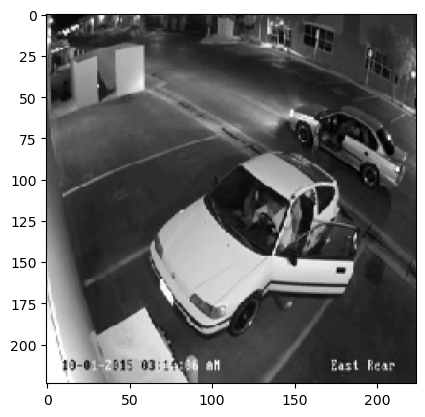

Stealing


In [9]:
# Get the first batch of images and labels
images, labels = next(train_generator)

# Display the first image
plt.imshow(images[0])
plt.show()

# Get the class indices
class_indices = train_generator.class_indices

# Find the index of the maximum value in the label
class_index = np.argmax(labels[0])

# Get the class name
class_name = list(class_indices.keys())[list(class_indices.values()).index(class_index)]

# Print the class name
print(class_name)

The code has correctly loaded the image and label

## Loading Model

In [10]:
print("Loading the MobileNetV2 model with pre-trained weights...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


print("Freezing the base model...")
for layer in base_model.layers:
    layer.trainable = False

print("Adding a new top layer...")
x = Flatten()(base_model.output) # Flatten the output of the base model
x = Dense(num_classes, activation='softmax')(x) # Add a new dense layer with softmax activation function

print("Defining the new model...")
model = Model(inputs=base_model.input, outputs=x)

print("Compiling the model...")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Defining the callbacks...")
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

Loading the MobileNetV2 model with pre-trained weights...
Freezing the base model...
Adding a new top layer...
Defining the new model...
Compiling the model...
Defining the callbacks...


In [11]:
# Print the number of layers in the model
print(f"Number of layers in the model: {len(base_model.layers)}")

# Print the number of parameters in the model
print(f"Number of parameters in the model: {base_model.count_params()}")

Number of layers in the model: 154
Number of parameters in the model: 2257984


## Training and Evaluation

In [11]:
print("Starting training...")
history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping, model_checkpoint])
print("Training completed.")

print("Evaluating the model on test set...")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

print("Saving the model...")
model.save('final_model.h5')
print("Model saved.")




Starting training...
Epoch 1/5
19097/19097 [==============================] - 5691s 298ms/step - loss: 2.5363 - accuracy: 0.9236 - val_loss: 1.3650 - val_accuracy: 0.9666
Epoch 2/5
19097/19097 [==============================] - 4701s 246ms/step - loss: 1.2453 - accuracy: 0.9715 - val_loss: 0.9384 - val_accuracy: 0.9794
Epoch 3/5
19097/19097 [==============================] - 5903s 309ms/step - loss: 0.8439 - accuracy: 0.9816 - val_loss: 0.5218 - val_accuracy: 0.9884
Epoch 4/5
19097/19097 [==============================] - 1731s 91ms/step - loss: 0.6670 - accuracy: 0.9866 - val_loss: 0.6454 - val_accuracy: 0.9895
Epoch 5/5
19097/19097 [==============================] - 1787s 94ms/step - loss: 0.5731 - accuracy: 0.9894 - val_loss: 0.7445 - val_accuracy: 0.9867
Training completed.
Evaluating the model on test set...
6366/6366 [==============================] - 1503s 236ms/step - loss: 0.7352 - accuracy: 0.9868
Test Loss: 0.735197126865387, Test Accuracy: 0.9868286848068237
Saving the mode

The model has been saved after training and the test accuracy of 98% is really good which means our model has triained well and has not overfitted or underfitted

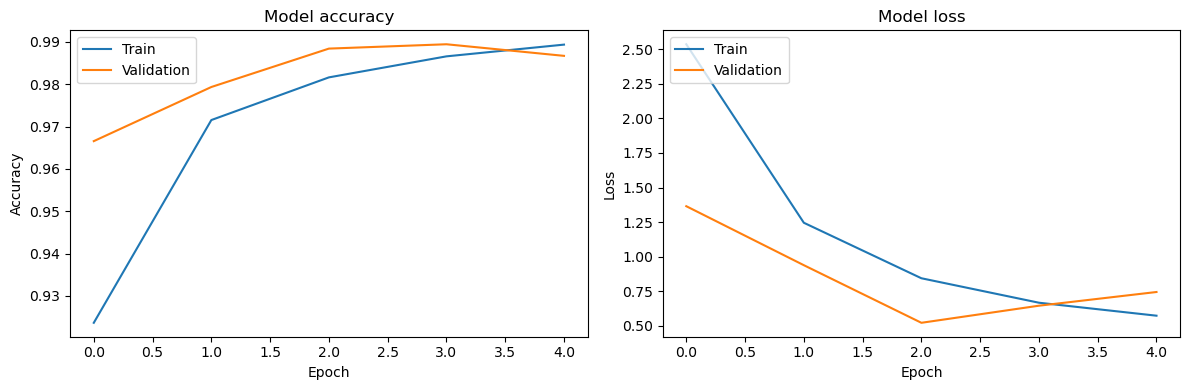

In [12]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

As we can observe from the graph, the accuracy increases and the loss decreases with each epoch

## Prediction

In [5]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('./best_model.h5')

print("The model has been loaded.")

The model has been loaded.


1/1 [==============================] - 0s 31ms/step


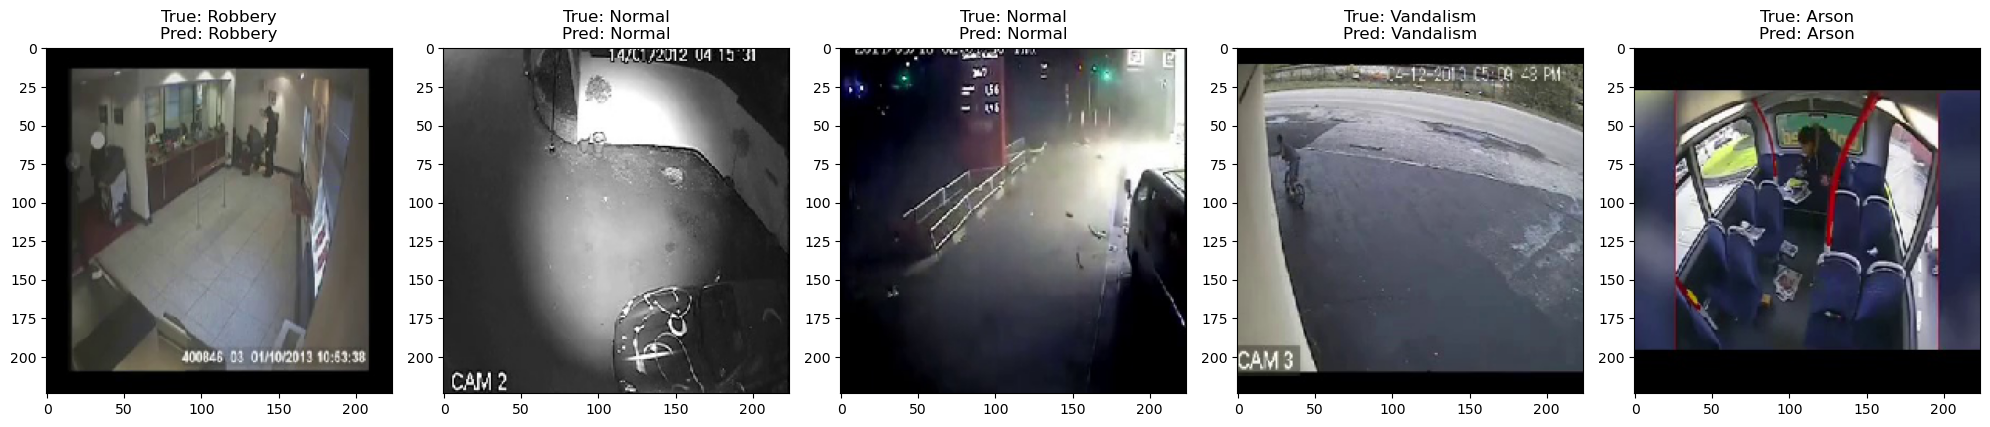

In [8]:
# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Select 5 random batches from the test generator
random_batches = np.random.choice(len(test_generator), size=5)
random_images = []
random_labels = []

for batch in random_batches:
    # Get the images and labels from the batch
    images, labels = test_generator[batch]
    
    # Select a random image and label from the batch
    idx = np.random.choice(images.shape[0])
    random_images.append(images[idx])
    random_labels.append(labels[idx])

# Predict the labels of the random images
predictions = model.predict(np.array(random_images))
predicted_labels = np.argmax(predictions, axis=1)

# Plot the random images with their true and predicted labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    ax.imshow(random_images[i])
    true_label = class_labels[np.argmax(random_labels[i])]
    predicted_label = class_labels[predicted_labels[i]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()

The model predicted all the images correctly